# Задача

Определить качество вина.  
Необходимо решить задачу классификации с использованием SVM и подобрать наилучшее ядро.

# Импорт

In [ ]:
!pip install catboost -q
!pip install category_encoders -q
!pip install hyperopt

In [ ]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from sklearn import metrics #метрики
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score

# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce

import seaborn as sns

from functools import partial

import hyperopt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

In [ ]:
#В колабе импортируем все необходимые библиотеки
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1IWWIy-Lwi0XCSxEuevUl3zkwnZG-Hb6Q"})
# https://drive.google.com/file/d/1IWWIy-Lwi0XCSxEuevUl3zkwnZG-Hb6Q/view?usp=sharing
download.GetContentFile("winequality-red.zip")

# Данные

Датасет содержит информацию о красных винах и их составе.   
Целевой переменной является столбец "quality". Это метрика качества вина по шкале от 3 до 8.  
Данная оценка является субъективной, т.к оценкой вина занимается дегустатор.  
Поэтому производить чистку от выбросов мы производить не будем.  
Иногда аномальные значения признаков могут положительно влиять на вкус.  

Данные состоят из химических показателей вин:  

| Название признака | Перевод |   
| ------------- | --------- |
| 'fixed acidity' |«фиксированная кислотность» |
| 'volatile acidity'|«летучая кислотность» |
| 'citric acid'|«лимонная кислота»|
| 'residual sugar' |«остаточный сахар»|
| 'chlorides' |«хлориды»|
|'total sulfur dioxide'| «общий диоксид серы»|
| 'free sulfur dioxide' | «свободный диоксид серы» |
| 'density' | «плотность»|
| 'pH' |«рН» |
| 'sulphates'| «сульфаты»|
| 'alcohol' | «спирт»|
| 'quality' |«качество»|

In [ ]:
df = pd.read_csv('winequality-red.zip', sep=';')
# удаляем дубликаты
df.drop_duplicates(inplace=True, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 127.5 KB


In [ ]:
#вывести нулевые значения
df[df.isnull().any(1)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


Пропусков в данных нет

In [ ]:
df.sample(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1011,6.7,0.640,0.23,2.1,0.080,11.0,119.0,0.99538,3.36,0.70,10.9,5
419,9.4,0.685,0.11,2.7,0.077,6.0,31.0,0.99840,3.19,0.70,10.1,6
745,6.8,0.490,0.22,2.3,0.071,13.0,24.0,0.99438,3.41,0.83,11.3,6


In [ ]:
#посмотрим на сводку по данным
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Уровни медиан и средних можно оценить как равномерные, но максимальные и минимальные уровни зачастую в разы выше чем сумма средней и стандартного отклонения, т.е. разброс великоват.
Однако выбросы мы чистить не будем.
Проведем нормализацию и стандартизацию, c использованием устойчивого к выбросам нормализатора RobustScaler

In [ ]:
# подготовим пайплайн для будущих преобразований
pipeline_std = Pipeline([('rs',RobustScaler()),('ss', StandardScaler())])

# Преобразование признаков

In [ ]:
# скопируем данные
data = df.copy()

In [ ]:
# подготовим целевой признак для преобразования в бинарный
data['quality'].value_counts()

5    577
6    535
7    167
4     53
8     17
3     10
Name: quality, dtype: int64

In [ ]:
# Преобразуем целевой признак качества вина
data.loc[:,'quality'] = data['quality'].apply(
    lambda x: 'bad wine' if x < 6.5 else 'good wine'
    )

# Анализ распределений признаков

<Figure size 640x480 with 0 Axes>

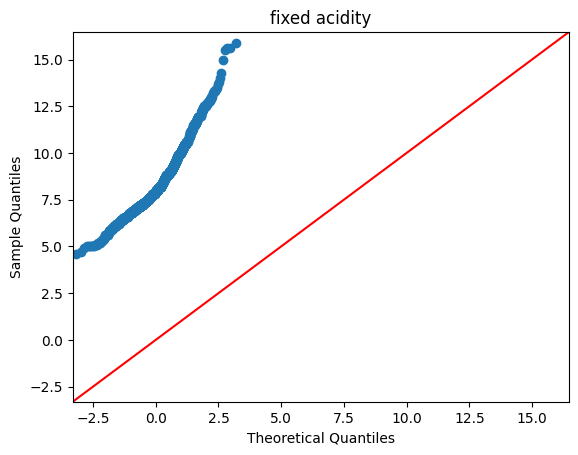

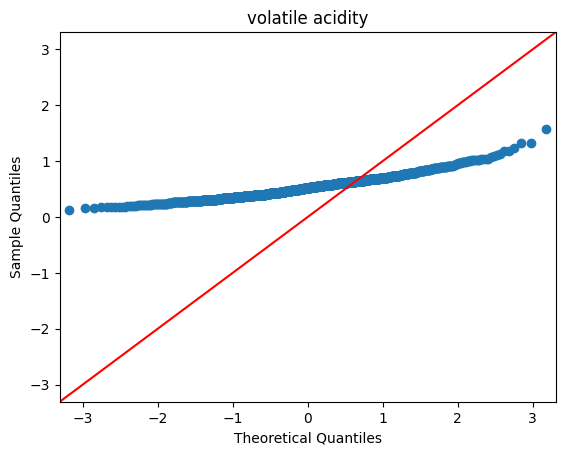

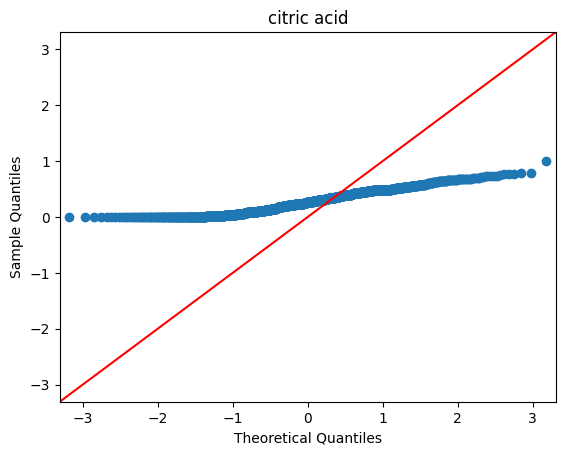

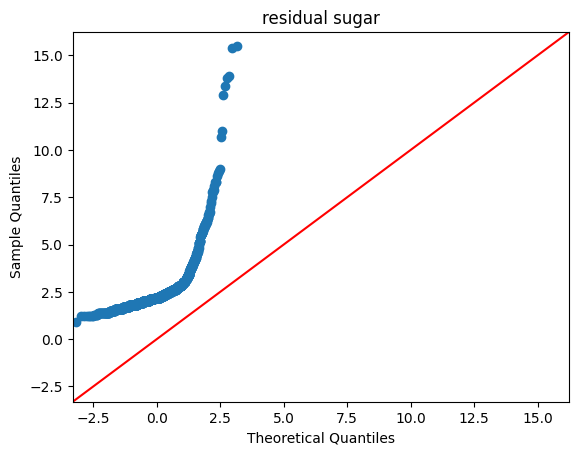

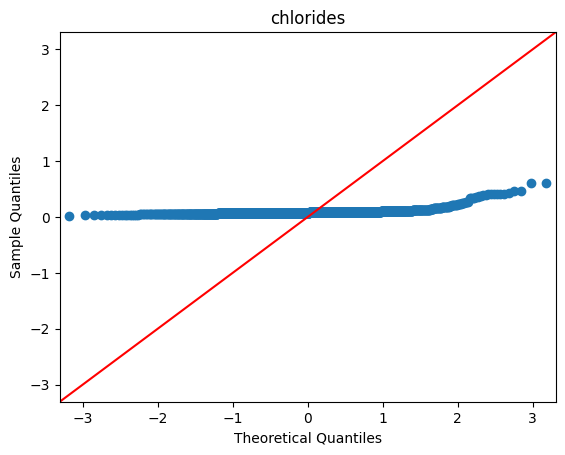

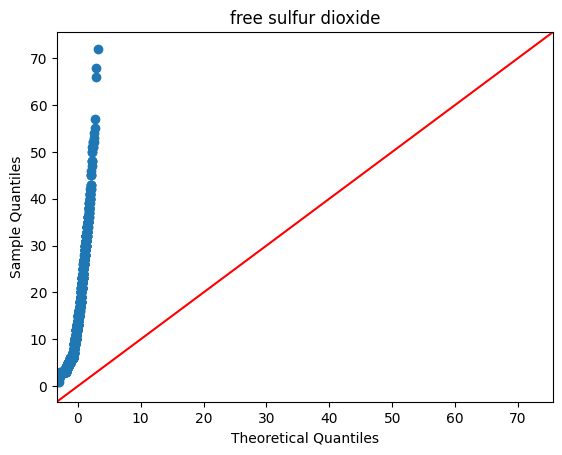

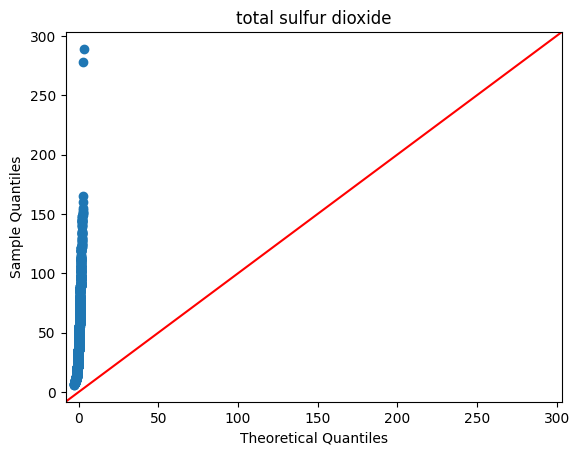

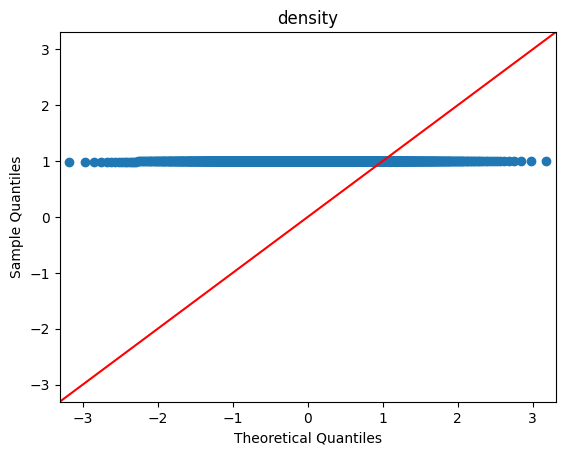

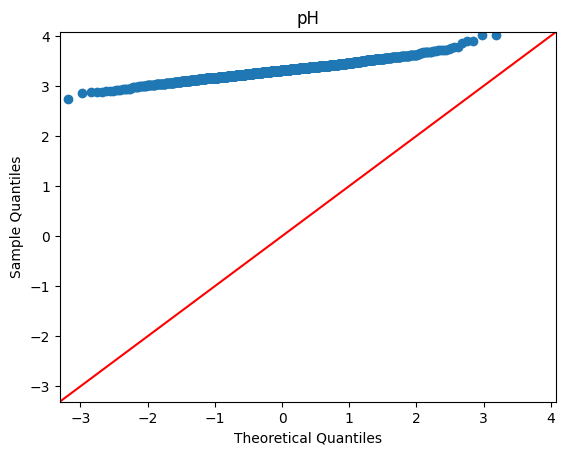

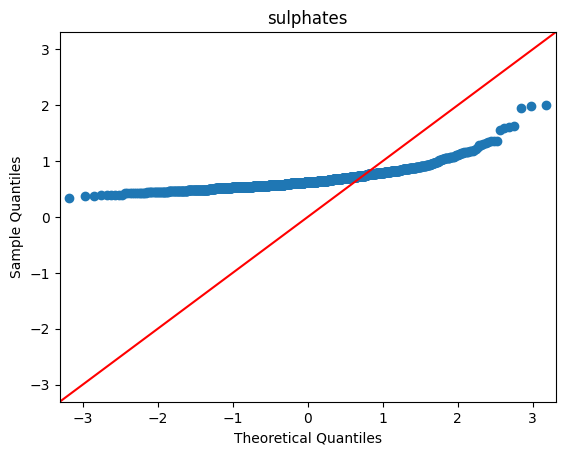

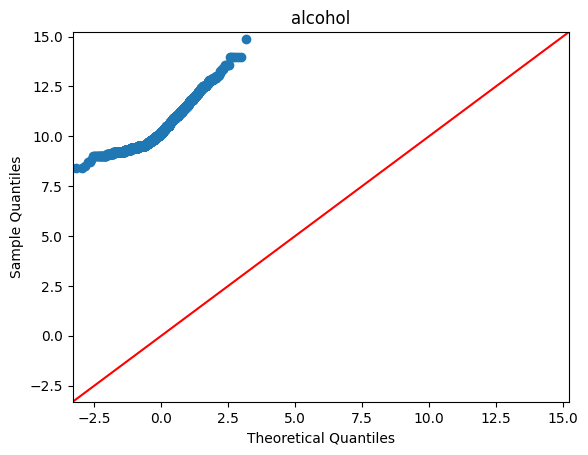

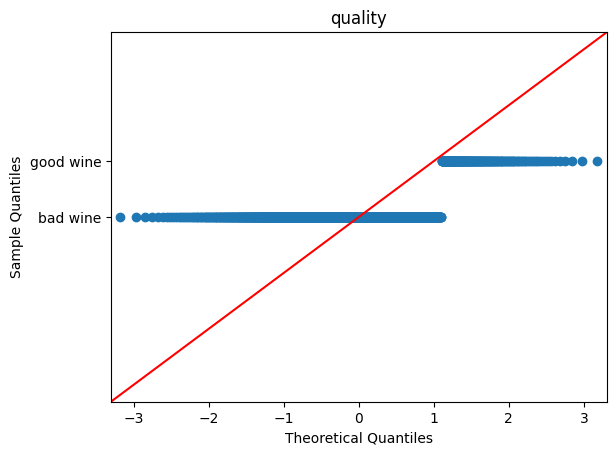

In [ ]:
plt.figure()
for _ in data.columns:
#create Q-Q plot with 45-degree line added to plot
  fig = sm.qqplot(data[_], line='45')
  plt.title(_)
  plt.show()


Судя по графику QQ-plot ни одного нормально распределённого признака нет.
Будем нормализовать  и затем стандартизировать.

## Закодируем целевой признак

In [ ]:
# создаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
ord_encoder = ce.OrdinalEncoder(mapping=[{
    'col': 'quality',
    'mapping': {'bad wine': 0, 'good wine': 1}
    }])
# Преобразуем категориальный признак в числовой
data['quality_n'] = ord_encoder.fit_transform(data[['quality']])
data.sample(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_n
694,7.7,0.56,0.08,2.5,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,bad wine,0
503,12.3,0.50,0.49,2.2,0.089,5.0,14.0,1.0002,3.19,0.44,9.6,bad wine,0
375,12.8,0.84,0.63,2.4,0.088,13.0,35.0,0.9997,3.10,0.60,10.4,bad wine,0


<Axes: xlabel='quality', ylabel='Count'>

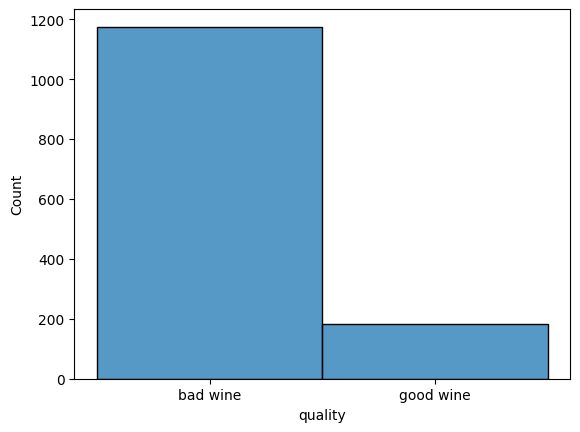

In [ ]:
# определим сбалансирванность признака
sns.histplot(data['quality'])

Наблюдается дисбаланс целевого признака, необходимо применить стратифицированное разделение.

## Добавим признаки

In [ ]:
# объединим похожие признаки
data['acid'] = data['volatile acidity'] + data['citric acid'] + data['fixed acidity']
data['dioxide'] = data['free sulfur dioxide'] + data['total sulfur dioxide']
#удалим объединённые признаки
data.drop(['fixed acidity', 'volatile acidity', 'citric acid', 'free sulfur dioxide', 'total sulfur dioxide'], axis= 1 , inplace= True )

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   residual sugar  1359 non-null   float64
 1   chlorides       1359 non-null   float64
 2   density         1359 non-null   float64
 3   pH              1359 non-null   float64
 4   sulphates       1359 non-null   float64
 5   alcohol         1359 non-null   float64
 6   quality         1359 non-null   object 
 7   quality_n       1359 non-null   int64  
 8   acid            1359 non-null   float64
 9   dioxide         1359 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 106.3+ KB


# Корреляционная матрица

<Axes: >

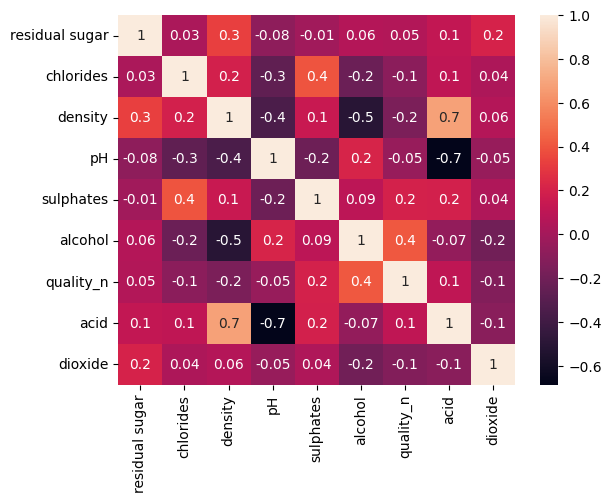

In [ ]:
# найдем наиболее скоррелированнные с целевым признаком признаки
h = data.corr()
sns.heatmap(h, annot = True, fmt='.1g')

Сильной корреляции между призаками не выявлено.  
С целевым признаком максимальная корреляция с признаком 'alcohol'.

In [ ]:
print('det(df_corr)):\n',round(np.linalg.det(h),7))
print(np.linalg.matrix_rank(h))

det(df_corr)):
 0.0369349
9


Определитель близок к нулю, матрица почти вырождена.  
Однако ранг показывает, что базис хороший, все признаки линейно независимы, матрица не вырождена.


# Разделение выборки

In [ ]:
X = data.drop(['quality', 'quality_n'], axis=1)
y = data['quality_n']
X_scaled = pipeline_std.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state = 42, test_size = 0.2)

# Baseline

In [ ]:
# используем в качестве пайплайна классическую логистическую регрессию
pipeline_base = Pipeline([('rs',RobustScaler()),('ss', StandardScaler()), ('lr', LogisticRegression())])
pipeline_base['lr'].fit(X_train, y_train)
y_pred = pipeline_base['lr'].predict(X_test)
print('Качество baseline')
print(metrics.classification_report(y_test, y_pred))

Качество baseline
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       235
           1       0.53      0.22      0.31        37

    accuracy                           0.87       272
   macro avg       0.71      0.59      0.62       272
weighted avg       0.84      0.87      0.84       272



# Подбор гиперпараметров

In [ ]:
# зададим пространство поиска гиперпараметров
space={
    'C': hp.choice('C', np.arange(0.05,10.0,0.1)),
    'gamma' : hp.choice(label = 'gamma',
                          options = ['scale', 'auto']),
    'kernel': hp.choice(label='kernel',
                          options=['linear', 'poly', 'rbf', 'sigmoid'])
      }

In [ ]:
trials = Trials() # используется для логирования результатов

In [ ]:
# создадим функцию, которую будет минимизировать алгоритм оптимизации гиперпараметров
def objective(space):
  model = SVC(**space)
  # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
  skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
  score = cross_val_score(estimator=model, X=X_train, y=y_train,
                            scoring='accuracy', cv=skf, n_jobs=-1)
  return  {'loss': -score.mean(), 'params': space, 'status': STATUS_OK}

In [ ]:
# запустим алгоритм оптимизации
best = fmin(objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 50,
            trials = trials,
            rstate=np.random.default_rng(42)
            )

100%|██████████| 50/50 [00:16<00:00,  3.10trial/s, best loss: -0.8886850173648795]


In [ ]:
print("Наилучшие значения гиперпараметров {}".format(best))

Наилучшие значения гиперпараметров {'C': 9, 'gamma': 1, 'kernel': 2}


# Модель SVC

In [ ]:
# создадим пайплайн для обучения модели на оптимальных гиперпараметров
model_svc = Pipeline([('rs',RobustScaler()),('ss', StandardScaler()),('SVC', SVC())])
model_svc.get_params()

{'memory': None,
 'steps': [('rs', RobustScaler()), ('ss', StandardScaler()), ('SVC', SVC())],
 'verbose': False,
 'rs': RobustScaler(),
 'ss': StandardScaler(),
 'SVC': SVC(),
 'rs__copy': True,
 'rs__quantile_range': (25.0, 75.0),
 'rs__unit_variance': False,
 'rs__with_centering': True,
 'rs__with_scaling': True,
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'SVC__C': 1.0,
 'SVC__break_ties': False,
 'SVC__cache_size': 200,
 'SVC__class_weight': None,
 'SVC__coef0': 0.0,
 'SVC__decision_function_shape': 'ovr',
 'SVC__degree': 3,
 'SVC__gamma': 'scale',
 'SVC__kernel': 'rbf',
 'SVC__max_iter': -1,
 'SVC__probability': False,
 'SVC__random_state': None,
 'SVC__shrinking': True,
 'SVC__tol': 0.001,
 'SVC__verbose': False}

In [ ]:
# добавим оптимальные гиперпараметры в пайплайн
model_svc.set_params(
    SVC__random_state=42,
    SVC__C=int(best['C']),
    SVC__gamma='auto',
    SVC__kernel= 'rbf'
    )

Pipeline(steps=[('rs', RobustScaler()), ('ss', StandardScaler()),
                ('SVC', SVC(C=9, gamma='auto', random_state=42))])

In [ ]:
# обучим алгоритм
model_svc['SVC'].fit(X_train, y_train)
# сделаем предсказания
y_test_svc = model_svc['SVC'].predict(X_test)
print('Качество SVC')
print(metrics.classification_report(y_test, y_test_svc))

Качество SVC
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       235
           1       0.67      0.38      0.48        37

    accuracy                           0.89       272
   macro avg       0.79      0.67      0.71       272
weighted avg       0.88      0.89      0.88       272



PЕКОМЕНДАЦИИ

Проанализируйте распределения переменных и корреляцию с таргетом.   
           
КРИТЕРИИ ОЦЕНИВАНИЯ   

2 балла	Сделан анализ (проанализированы распределения).          

# Confusion matrix

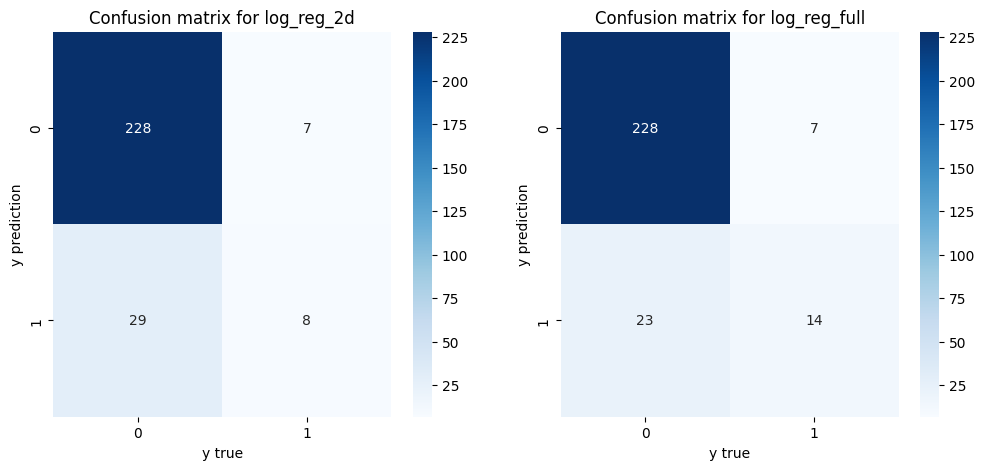

In [ ]:
#Строим матрицы ошибок для каждой из моделей
confusion_matrix1 = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix2 = metrics.confusion_matrix(y_test, y_test_svc)
#Визуализируем матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #фигура + 2 координатные плоскости
#Строим тепловую карту для первой матрицы ошибок
sns.heatmap(confusion_matrix1, annot=True, fmt='', ax=axes[0], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[0].set_title('Confusion matrix for log_reg_2d')
axes[0].set_xlabel('y true')
axes[0].set_ylabel('y prediction')
#Строим тепловую карту для второй матрицы ошибок
sns.heatmap(confusion_matrix2, annot=True, fmt='', ax=axes[1], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[1].set_title('Confusion matrix for log_reg_full')
axes[1].set_xlabel('y true')
axes[1].set_ylabel('y prediction');

# Выводы

Сводная таблица результатов работы моделей ML  

| Модель ML | accuracy |  
| --------- | -------- |   
| Baseline(LogisticRegression) | 0.87 |  
| SVC | 0.89 |

За счет использования модели с RBF ядром удалось повысить качество прогнозирования на 0.02.  
Анализ confusion matrix показывает, что увеличилось количество верных предсказаний категории 'good wine', и уменьшилось количество ошибочных прогнозов также по данному виду вина.  
По категории 'bad wine' показатели не изменились.
